# Classification - Double-down vs Hit vs Stay 

This notebook is for model building of the classification model to predict what is the best action to take next.

<u>***Setup***</u>

In [1]:
import os,copy
import sqlite3 as sql
import numpy as np

import pandas as pd
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt

import torch as tc
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm

## Pulling data

This is simply to connect to the db and pull the data to see what it looks like

In [2]:
# Specify the absolute path to the database file
db_file_path = '../data/game_state.db'

# Check if the database file exists
if os.path.exists(db_file_path):
    conn = sql.connect(db_file_path)
    hitstay_df = pd.read_sql_query('SELECT * FROM players_hitStay', conn)
else:
    print("Database file not found.")


In [4]:
print(f"{hitstay_df.shape=}")
hitstay_df.head(20)

hitstay_df.shape=(228, 14)


,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
0,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,50.0,70.0,70,"(Di 2,Sp A)",13,0,House,Hr 7,7,hit
1,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,50.0,70.0,70,"(Di 2,Sp A,Cl Q)",13,0,House,Hr 7,7,hit
2,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,0,50.0,70.0,70,"(Di 2,Sp A,Cl Q,Cl 5)",18,0,House,Hr 7,7,stay
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K)",12,0,House,Hr 7,7,hit
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K,Cl J)",22,1,House,Hr 7,7,bust
5,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,1,50.0,75.0,215,"(Hr 6,Di 9)",15,0,House,Hr 7,7,hit
6,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,1,50.0,75.0,215,"(Hr 6,Di 9,Sp 6)",21,0,House,Hr 7,7,stay
7,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,0,NaN,NaN,215,"(Sp 4,Hr 7)",11,0,House,Hr 7,7,hit
8,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,0,NaN,NaN,215,"(Sp 4,Hr 7,Cl 3)",14,0,House,Cl 3,3,hit
9,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,0,NaN,NaN,215,"(Sp 4,Hr 7,Cl 3,Sp J)",24,1,House,Sp J,10,bust


## Analysis

Here is a quick EDA to see what the lay of the land is in the data

In [5]:
dec_grp_df = hitstay_df.groupby(['player_choice','player_is_pc']) \
    .agg(decision_count=('player_name','count')) \
        .reset_index() \
            .sort_values('decision_count',ascending=False) \
                .fillna(0)

dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).head()

player_is_pc,0,1
player_choice,,
bust,24.0,6.0
double-down,20.0,0.0
hit,53.0,25.0
stay,71.0,29.0


,player_choice,player_is_pc,decision_count
5,stay,0,71
3,hit,0,53
6,stay,1,29
4,hit,1,25
0,bust,0,24
2,double-down,0,20
1,bust,1,6


<Axes: xlabel='player_choice'>

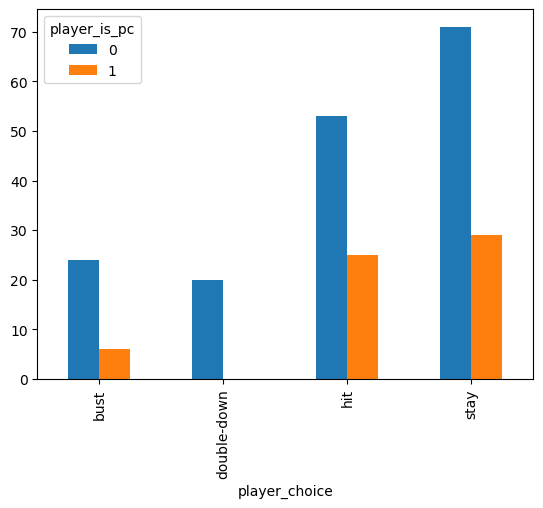

In [6]:
display(dec_grp_df.head(10))
# dec_grp_df.plot.bar(x='player_choice',y='decision_count')
dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()


In [7]:
hitstay_df.loc[hitstay_df.player_choice == 'double-down'].head()

,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
11,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,50.0,100,"(Cl A,Sp 3)",14,0,House,Sp A,11,double-down
16,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,100.0,200,"(Hr 6,Hr 2)",8,0,House,Sp 5,5,double-down
23,d9dfe2f1-826e-4ab1-9d40-439b2d613905,3,Joe,0,75.0,75.0,75,"(Sp 6,Hr 2)",8,0,House,Di 6,6,double-down
28,f8ee0a9c-0288-4407-86de-cc0a49531194,0,Joe,0,50.0,70.0,70,"(Hr 9,Sp 4)",13,0,House,Di 7,7,double-down
34,f8ee0a9c-0288-4407-86de-cc0a49531194,1,Albert,0,50.0,70.0,140,"(Sp 10,Di 4)",14,0,House,Cl 4,4,double-down


In [8]:
hitstay_df.loc[(hitstay_df.game_ID == 'd9dfe2f1-826e-4ab1-9d40-439b2d613905') & (hitstay_df.player_name == 'Albert')].head(10)

,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K)",12,0,House,Hr 7,7,hit
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K,Cl J)",22,1,House,Hr 7,7,bust
11,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,50.0,100,"(Cl A,Sp 3)",14,0,House,Sp A,11,double-down
12,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,100.0,100,"(Cl A,Sp 3,Cl 7)",21,0,House,Sp A,11,stay
16,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,100.0,200,"(Hr 6,Hr 2)",8,0,House,Sp 5,5,double-down
17,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,200.0,200,"(Hr 6,Hr 2,Cl 5)",13,0,House,Sp 5,5,hit
18,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,200.0,200,"(Hr 6,Hr 2,Cl 5,Cl 9)",22,1,House,Sp 5,5,bust
